<a href="https://colab.research.google.com/github/SSGrady/Movie-Recommendation-Sys/blob/main/Recommendation_System_StevenGrady.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! curl https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -o ml-latest-small.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  955k  100  955k    0     0  1983k      0 --:--:-- --:--:-- --:--:-- 1981k


##Movie Recommendation System: Collaborative Filtering + Kmeans + Matrix Factorization

In [3]:
import zipfile
with zipfile.ZipFile('ml-latest-small.zip', 'r') as zip_ref:
  zip_ref.extractall('data')

In [4]:
import pandas as pd
#|-- import the dataset --|

# dimensions of movies are (9742, 3)
movies_df = pd.read_csv('data/ml-latest-small/movies.csv')
# dimensions of ratings are (100836, 4)
ratings_df = pd.read_csv('data/ml-latest-small/ratings.csv')

In [5]:
# View movies_df
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#View ratings_df
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Mapping movie ID to movie name for each item
movies_names = movies_df.set_index('movieId')['title'].to_dict()

n_users = len(ratings_df.userId.unique())
m_items = len(ratings_df.movieId.unique())
matrix_nm = n_users * m_items

print("Number of unique users", n_users)
print("Number of unique items", m_items)
print("Full ratings matrix will contain", n_users*m_items, " elemnts")
print("Number of ratings is", ratings_df.shape[0])
print("So ",round(len(ratings_df)/matrix_nm*100, 2), "% of the matrix is full")
print("This means that we have an incredibly sparse dataset matrix")
print("To work with global scale, storing a full matrix in memory will be the challenge")
print("Matrix factorization can realize the rating matrix implicitly (don't need all data!)")

Number of unique users 610
Number of unique items 9724
Full ratings matrix will contain 5931640  elemnts
Number of ratings is 100836
So  1.7 % of the matrix is full
This means that we have an incredibly sparse dataset matrix
To work with global scale, storing a full matrix in memory will be the challenge
Matrix factorization can realize the rating matrix implicitly (don't need all data!)


In [8]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm.notebook import tqdm as tqdm

class MatrixFactorization(torch.nn.Module):
  def __init__(self, n_users, m_items, n_factors=10):
    super().__init__()
    #create user embeddings - i.e. look up table for the input
    self.user_factors = torch.nn.Embedding(n_users, n_factors)
    # create item embeddings - i.e. look up tables
    self.item_factors = torch.nn.Embedding(m_items, n_factors)

    # tuneable parameters
    self.user_factors.weight.data.uniform_(0, 0.05)
    self.item_factors.weight.data.uniform_(0, 0.05)

  def forward(self, data):
    # matrix multiplication
    users, items = data[:,0], data[:,1]
    return (self.user_factors(users)*self.item_factors(items)).sum(1)

  def predict(self, user, item):
    return self.forward(user, item)

In [9]:
# Creating the dataloader for PyTorch - helps transform data to ML readiness
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

# An efficient and convenient way to manage/process data for training
class Loader(Dataset):
  def __init__(self):
      # not recommended but is possible since ratings_df is stored in memory
      self.ratings = ratings_df.copy()
      # Extract all user IDs and movie IDs
      users = ratings_df.userId.unique()
      movies = ratings_df.movieId.unique()

      #--- Producing new continuous IDs for users and movies ---

      # Unique values : index
      self.userid2idx = {o:i for i,o in enumerate(users)}
      self.movieid2idx = {o:i for i,o in enumerate(movies)}

      # Obtained continuous ID for users and movies
      self.idx2userid = {i:o for o,i in self.userid2idx.items()}
      self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}

      # return the id from the indexed values as noted in the lambda function down below.
      self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
      self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])


      self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
      self.y = self.ratings['rating'].values
      self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models.)

  # returns number of smaples in the dataset
  def __len__(self):
    return len(self.ratings)
  # returns a specified sample at the given index
  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [10]:
num_epochs = 5
cuda = torch.cuda.is_available()

print("Is running on GPU: ", cuda)

model = MatrixFactorization(n_users, m_items, n_factors=12)
print("\n", model)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

if cuda:
    model = model.cuda()

# MSE loss
loss_fn = torch.nn.MSELoss()

# ADAM optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train data
train_set = Loader()
train_loader = DataLoader(train_set, 50, shuffle=True)

Is running on GPU:  False

 MatrixFactorization(
  (user_factors): Embedding(610, 12)
  (item_factors): Embedding(9724, 12)
)
user_factors.weight tensor([[0.0035, 0.0101, 0.0050,  ..., 0.0186, 0.0328, 0.0279],
        [0.0253, 0.0190, 0.0029,  ..., 0.0491, 0.0004, 0.0051],
        [0.0473, 0.0209, 0.0091,  ..., 0.0461, 0.0280, 0.0130],
        ...,
        [0.0326, 0.0305, 0.0290,  ..., 0.0392, 0.0169, 0.0211],
        [0.0265, 0.0008, 0.0425,  ..., 0.0308, 0.0483, 0.0142],
        [0.0185, 0.0235, 0.0210,  ..., 0.0189, 0.0266, 0.0049]])
item_factors.weight tensor([[0.0253, 0.0208, 0.0240,  ..., 0.0271, 0.0075, 0.0365],
        [0.0174, 0.0455, 0.0147,  ..., 0.0351, 0.0161, 0.0371],
        [0.0255, 0.0172, 0.0172,  ..., 0.0195, 0.0019, 0.0172],
        ...,
        [0.0249, 0.0030, 0.0020,  ..., 0.0408, 0.0181, 0.0199],
        [0.0051, 0.0042, 0.0124,  ..., 0.0398, 0.0047, 0.0232],
        [0.0026, 0.0120, 0.0282,  ..., 0.0489, 0.0268, 0.0133]])


In [11]:
epoch_losses = []

# Training loop
for epoch in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    epoch_loss = sum(losses) / len(losses)
    epoch_losses.append(epoch_loss)
    print("Epoch #{}".format(epoch), "Loss:", epoch_loss)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0 Loss: 8.034584004629586
Epoch #1 Loss: 2.3565784026386125
Epoch #2 Loss: 1.3986259556726826
Epoch #3 Loss: 1.0649868674690792
Epoch #4 Loss: 0.9104866399348934


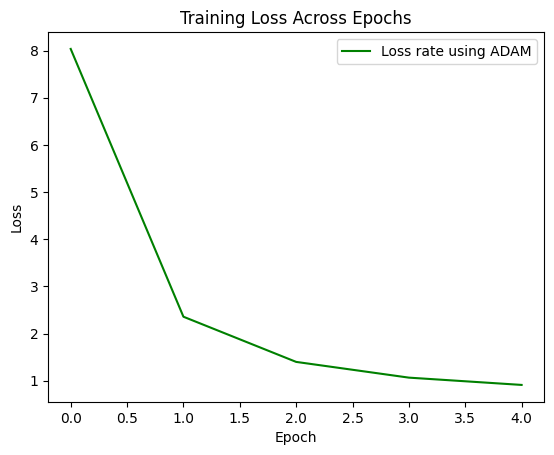

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), epoch_losses, label='Loss rate using ADAM', c='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.legend()
plt.show()
plt.close()

In [13]:
from sklearn.cluster import KMeans

# unique movie factor weights
trained_movie_embeddings = model.item_factors.weight.data.cpu().numpy()

# Fit the clusters based on the movie weights
kmeans = KMeans(n_clusters=10, random_state=0, n_init=10).fit(trained_movie_embeddings)

# If movies are clustered, then they have the same genre
# Note: algorithm is unfamiliar with the movie names - relationships are
  # found by looking at the (numbers) user responses to movie selections
def CollaborativeFiltering():
  for cluster in range(10):
    print("Cluster #{}".format(cluster))
    movs = []
    for movidx in np.where(kmeans.labels_ == cluster)[0]:
      movid = train_set.idx2movieid[movidx]
      rat_count = ratings_df.loc[ratings_df['movieId']==movid].count()[0]
      movs.append((movies_names[movid], rat_count))
    for mov in sorted(movs, key=lambda tup: tup[1], reverse=True)[:10]:
      print("\t", mov[0])

CollaborativeFiltering()

Cluster #0
	 Anaconda (1997)
	 Battlefield Earth (2000)
	 Superman IV: The Quest for Peace (1987)
	 Karate Kid, Part III, The (1989)
	 Ultraviolet (2006)
	 Dungeons & Dragons (2000)
	 Rambo III (1988)
	 Problem Child (1990)
	 Flintstones in Viva Rock Vegas, The (2000)
	 Dumb and Dumberer: When Harry Met Lloyd (2003)
Cluster #1
	 Independence Day (a.k.a. ID4) (1996)
	 Batman (1989)
	 True Lies (1994)
	 Speed (1994)
	 Men in Black (a.k.a. MIB) (1997)
	 Mission: Impossible (1996)
	 Mrs. Doubtfire (1993)
	 Stargate (1994)
	 Titanic (1997)
	 Pretty Woman (1990)
Cluster #2
	 Ace Ventura: Pet Detective (1994)
	 Mask, The (1994)
	 Star Wars: Episode I - The Phantom Menace (1999)
	 Austin Powers: The Spy Who Shagged Me (1999)
	 Waterworld (1995)
	 Net, The (1995)
	 Cliffhanger (1993)
	 Matrix Reloaded, The (2003)
	 Natural Born Killers (1994)
	 Mummy, The (1999)
Cluster #3
	 Forrest Gump (1994)
	 Shawshank Redemption, The (1994)
	 Pulp Fiction (1994)
	 Silence of the Lambs, The (1991)
	 Matrix,